In [1]:
import numpy as np
from scipy.integrate import odeint
import tensorflow as tf
import matplotlib.pyplot as plt
from utils_NSS_SINDy import *
import time
from datetime import datetime

In [2]:
#%% Define how many percent of noise you need
NoisePercentage=30

#%% Simulate
# Define the random seed for the noise generation
np.random.seed(4)

# Define the parameters
p0=np.array([1,0.5])

# Define the initial conditions
x0=np.array([1,2])

# Define the time points
T=10.0
dt=0.01

t=np.linspace(0.0,T,int(T/dt))

In [3]:
# Now simulate the system
x=odeint(Lotka,x0,t,args=(p0,),rtol = 1e-12, atol = 1e-12)
dx=np.transpose(Lotka(np.transpose(x), 0, p0))

In [4]:
# Get the size info
stateVar,dataLen=np.transpose(x).shape

# Generate the noise
NoiseMag=[np.std(x[:,i])*NoisePercentage*0.01 for i in range(stateVar)]
Noise=np.hstack([NoiseMag[i]*np.random.randn(dataLen,1) for i in range(stateVar)])

# Add the noise and get the noisy data
xn=x+Noise
  
# Test the SINDy
N_SINDy_Iter=15
disp=0
NormalizeLib=0
libOrder=3
lam=0.2

# SoftStart?
softstart=0

(-1.7672938309767745, 12.81288492659819, -2.212899909666543, 8.875541016592448)

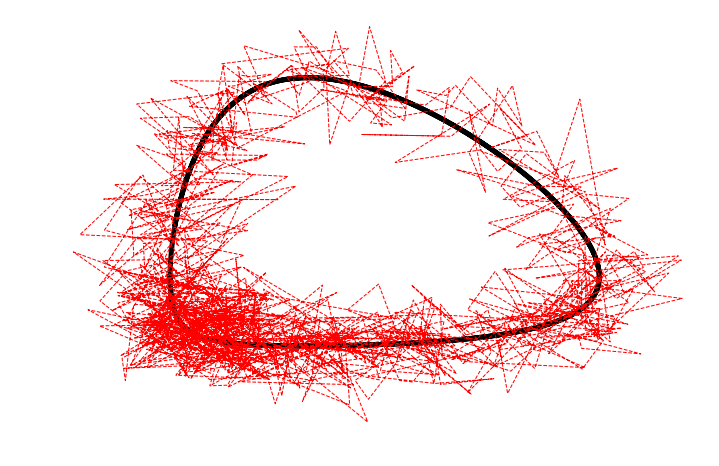

In [16]:

#%% Now plot the result of Lorenz

lw=5

plt.figure(figsize = (12,8))
pp1=plt.plot(x[:,0],x[:,1],linewidth=lw,color='k',linestyle='-')
pp1=plt.plot(xn[:,0],xn[:,1],linewidth=1,color='red',linestyle='--')
plt.ylabel('x')
plt.grid(False)
plt.axis('off')
#plt.savefig("Lotka_NoiseLevel"+str(NoisePercentage)+".pdf")


In [6]:
#%% Define a neural network
# Check the GPU status
CheckGPU()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.






The GPU is available








In [7]:
# Define the data type
dataType=tf.dtypes.float32

dh=tf.constant(dt)

#%% Define the data
# Define the prediction step
q=1

# Get the middle part of the measurement data (it will be define as constant)
Y=tf.constant(xn,dtype=dataType)
Y0=tf.constant(GetInitialCondition(xn,q,dataLen),dtype=dataType)

# Ge the forward and backward measurement data (it is a constant that wouldn't change)
Ypre_F,Ypre_B=SliceData(xn,q,dataLen)
Ypre_F=tf.constant(Ypre_F,dtype=dataType)
Ypre_B=tf.constant(Ypre_B,dtype=dataType)

# Get the weight for the error
ro=0.9
weights=tf.constant(DecayFactor(ro,stateVar,q),dtype=dataType)

if softstart==1:
    # Soft Start
    NoiseEs,xes=approximate_noise(np.transpose(xn), 20)
    NoiseEs=np.transpose(NoiseEs)
    xes=np.transpose(xes)
else:
    # Hard Start
    NoiseEs=np.zeros((xn.shape[0],xn.shape[1]))
    xes=xn-NoiseEs

dxes=CalDerivative(xes,dt,1)

# Get the initial guess of noise, we make a random guess here. For beteer performance you could first smooth the data and guess the noise. 
NoiseVar=tf.Variable(NoiseEs,dtype=tf.dtypes.float32)

# Get the initial guess of the SINDy parameters
Theta=Lib(xes,libOrder)

Xi0=SINDy(Theta,dxes,lam,N_SINDy_Iter,disp,NormalizeLib)
print(Xi0)

# Define the initial guess of the selection parameters
Xi=tf.Variable(Xi0,dtype=dataType)

# Set the initial active matrix
Xi_act=tf.constant(np.ones(Xi0.shape),dtype=dataType)

#%% First plot the noise: true v.s. identified
StartIndex=500 # Choose how many noise data point you would like to plot
EndIndex=700


The first dimension of the input data: 1000
The second dimension of the input data: 2
[[ 0.          0.        ]
 [12.82565391 -1.7706297 ]
 [ 0.          0.        ]
 [ 0.          0.41537341]
 [-5.27304759  0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.46415485  0.        ]]


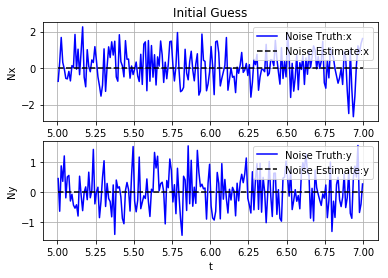

In [8]:
plt.figure()
plt.subplot(2,1,1)
plt.title("Initial Guess")
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,0],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseVar.numpy()[StartIndex:EndIndex,0],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Nx')
plt.xlabel('t')
plt.legend(['Noise Truth:x', 'Noise Estimate:x'],loc='upper right')
plt.grid(True)

plt.subplot(2,1,2)
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,1],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseVar.numpy()[StartIndex:EndIndex,1],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Ny')
plt.xlabel('t')
plt.legend(['Noise Truth:y', 'Noise Estimate:y'],loc='upper right')
plt.grid(True)



In [9]:
#%% Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=1e-09)

#%% Finally start training!
Nloop=5
N_train=5000

# Set a list to store the noise value
NoiseList=[]
NoiseIDList_SingleRun=[]
TrainTimeList_SingleRun=np.zeros((Nloop,1))
Enoise_error_List_SingleRun=np.zeros((Nloop,1))
Evector_field_error_list_SingleRun=np.zeros((Nloop,1))
Epre_error_list_SingleRun=np.zeros((Nloop,1))
x_sim_list_SingleRun=[]
Xi_List_SingleRun=[]

for k in range(Nloop):
    print("Runing the loop ",str(k+1))
    # Denoise the signal
    NoiseID,totalTime=Train_NSS_SINDy(Y,Y0,Ypre_F,Ypre_B,NoiseVar,Xi,Xi_act,weights,dt,q,stateVar,dataLen,optimizer,N_train)
    
    print("\t Current loop takes ",totalTime)
    # After the first iteration, minus the noise identified from the noisy measurement data
    xes=xn-NoiseID
    xes=xes[q+1:-q-1,:]
    dxes=CalDerivative(xes,dt,1)
         
    print("Current Xi result")
    print(Xi)
    
    # Do SINDy on the denoised data
    Theta=Lib(xes,libOrder)
    Xi0=SINDy(Theta,dxes,lam,N_SINDy_Iter,disp,NormalizeLib)
    
    # Do SINDy on the denoised data
    index_min=abs(Xi.numpy())>lam
    Xi_act_dum=Xi_act.numpy()*index_min.astype(int)
    Xi_num=Xi.numpy()
    Xi_num=Xi_num*Xi_act_dum
    index_min=Xi_act_dum.astype(bool)
    
    # Regress
    for r in range(xes.shape[1]):
        Xi_num[index_min[:,r],r]=solve_minnonzero(Theta[:,index_min[:,r]],dxes[:,r])
    
    # Print the new initial start point
    print("New Xi result")
    print(Xi_num)
    
    # Determine which term should we focus on to optimize next
    Xi_act=tf.constant(Xi_act_dum,dtype=tf.dtypes.float32)
    Xi=tf.Variable(Xi_num,dtype=tf.dtypes.float32)
    
    # Calculate the performance
    Enoise_error,Evector_field_error,Epre_error,x_sim=ID_Accuracy_SINDy(x,dx,Noise,NoiseID,LibGPU,Xi,dataLen,dt)
    
    # Print the performance
    print("\t\t The error between the true noise and estimated noise is:",Enoise_error,"\n")
    print("\t\t The error between the true vector field and estimated vector field is:",Evector_field_error,"\n")
    print("\t\t The error between the true trajector and simulted trajectory is:",Epre_error,"\n")
    
    NoiseIDList_SingleRun.append(NoiseID)
    x_sim_list_SingleRun.append(x_sim)
    TrainTimeList_SingleRun[k]=totalTime
    Enoise_error_List_SingleRun[k]=Enoise_error
    Evector_field_error_list_SingleRun[k]=Evector_field_error
    Epre_error_list_SingleRun[k]=Epre_error
    Xi_List_SingleRun.append(Xi.numpy())
    


Runing the loop  1
5482.90723
547.397705
80.1070786
20.888216
7.85758972
	 Current loop takes  63.52721905708313
Current Xi result
<tf.Variable 'Variable:0' shape=(9, 2) dtype=float32, numpy=
array([[-2.3599606e+00, -2.6450651e-02],
       [ 9.0852671e+00, -9.1720581e-01],
       [ 1.0414197e+00,  3.5046671e-02],
       [-1.9504499e+00, -3.6214891e-01],
       [-3.2647331e+00, -1.9545436e-01],
       [-8.2426742e-02, -2.3434805e-03],
       [ 1.8264273e-01,  6.3706219e-02],
       [-6.3669384e-02,  3.4721673e-02],
       [ 3.9223674e-01,  3.3977505e-02]], dtype=float32)>
The first dimension of the input data: 996
The second dimension of the input data: 2
New Xi result
[[ 1.38676257e+00 -0.00000000e+00]
 [-7.24246415e-04 -1.96994929e+00]
 [-5.62866074e-02  0.00000000e+00]
 [-3.96913713e-01  4.79704984e-01]
 [-5.72708610e-02 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00]
 [-2.34559783e-03  0.00000000e+00]]
		 The 

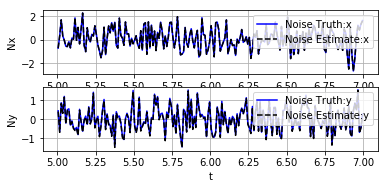

In [10]:
#%% Now plot the noise signal speration result

# First plot the noise: true v.s. identified
StartIndex=500 # Choose how many noise data point you would like to plot
EndIndex=700

plt.figure()
plt.subplot(3,1,1)
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,0],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseID[StartIndex:EndIndex,0],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Nx')
plt.xlabel('t')
plt.legend(['Noise Truth:x', 'Noise Estimate:x'],loc='upper right')
plt.grid(True)

plt.subplot(3,1,2)
pp1=plt.plot(t[StartIndex:EndIndex],Noise[StartIndex:EndIndex,1],linewidth=1.5,color='b')
pp1=plt.plot(t[StartIndex:EndIndex],NoiseID[StartIndex:EndIndex,1],linewidth=1.5,color='k',linestyle='--')
plt.ylabel('Ny')
plt.xlabel('t')
plt.legend(['Noise Truth:y', 'Noise Estimate:y'],loc='upper right')
plt.grid(True)

(-3.692250681098011, 3.692250681098011)

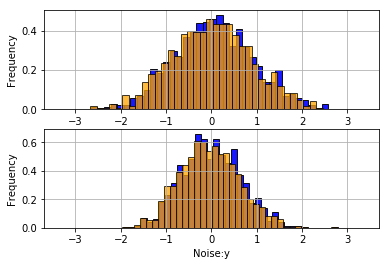

In [11]:
#%%
n_bins=int(180/5)
x_scale=np.linspace(-4*max(NoiseMag), 4*max(NoiseMag), 1000)

plt.figure()
plt.subplot(2,1,1)
plt.grid(True)
pp6=plt.hist(Noise[:,0], bins = n_bins, color = 'blue', alpha=0.9,edgecolor = 'black',density=True)
pp6=plt.hist(NoiseID[:,0], bins = n_bins, color = 'orange', alpha=0.75,edgecolor = 'black',density=True)
plt.ylabel('Frequency')
plt.xlabel('Noise:x')
axes = plt.gca()
axes.set_xlim([-4*max(NoiseMag),4*max(NoiseMag)])

plt.subplot(2,1,2)
plt.grid(True)
pp6=plt.hist(Noise[:,1], bins = n_bins, color = 'blue', alpha=0.9,edgecolor = 'black',density=True)
pp6=plt.hist(NoiseID[:,1], bins = n_bins, color = 'orange', alpha=0.75,edgecolor = 'black',density=True)
plt.ylabel('Frequency')
plt.xlabel('Noise:y')
axes = plt.gca()
axes.set_xlim([-4*max(NoiseMag),4*max(NoiseMag)])

(0.5256327035688595,
 10.961713225053948,
 -0.1106043739953741,
 7.412720554098583)

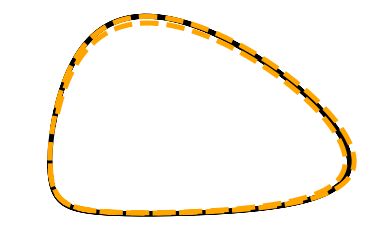

In [12]:
plt.figure()
pp1=plt.plot(x[:,0],x[:,1],linewidth=lw,color='k',linestyle='-')
pp1=plt.plot(xn[:,0]-NoiseID[:,0],xn[:,1]-NoiseID[:,1],linewidth=lw,color='orange',linestyle='--')
plt.ylabel('x')
plt.grid(False)
plt.axis('off')


In [13]:
Enoise_error,Evector_field_error,Epre_error,x_sim=ID_Accuracy_SINDy(x,dx,Noise,NoiseID,LibGPU,Xi,dataLen,dt)

print("The error between the true noise and estimated noise is:",Enoise_error)
print("The error between the true vector field and estimated vector field is:",Evector_field_error)
print("The error between the true trajector and simulted trajectory is:",Epre_error)

The error between the true noise and estimated noise is: 0.02916671362324358
The error between the true vector field and estimated vector field is: 0.0015696810767597761
The error between the true trajector and simulted trajectory is: 0.0007998747991163858


Text(0.5, 0, 'Loop Index')

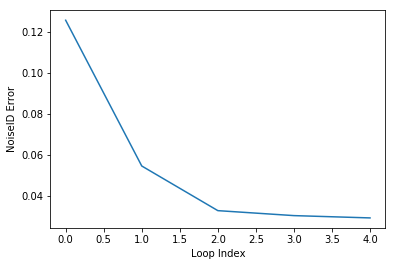

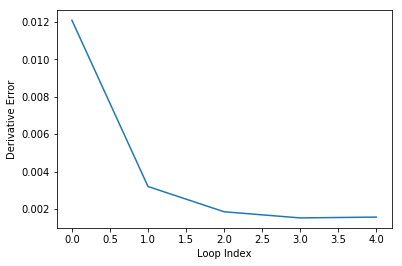

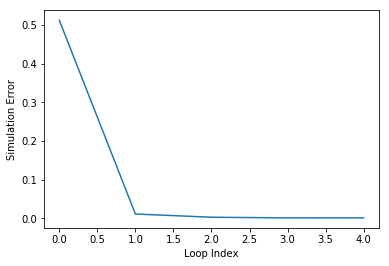

In [14]:
plt.figure()
plt.plot(Enoise_error_List_SingleRun)
plt.ylabel('NoiseID Error')
plt.xlabel('Loop Index')

plt.figure()
plt.plot(Evector_field_error_list_SingleRun)
plt.ylabel('Derivative Error')
plt.xlabel('Loop Index')

plt.figure()
plt.plot(Epre_error_list_SingleRun)
plt.ylabel('Simulation Error')
plt.xlabel('Loop Index')